In [1]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from clip_embeddings_generator import ClipEmbeddingsGenerator, draw_images
from pymilvus import (
    connections,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    MilvusClient,
)
import pymilvus
import os
import torch
import numpy as np

ImportError: cannot import name 'draw_images' from 'clip_embeddings_generator' (/home/pablo/host_data/clip_embeddings_generator.py)

In [36]:
client = MilvusClient(uri="http://milvus-standalone:19530")

In [37]:
fields = [
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True),
]
schema = CollectionSchema(fields, description="Avatar collection")

# Create collection
collection_name = "avatar_collection"
if client.has_collection(collection_name):
    client.drop_collection(collection_name)

collection = Collection(name=collection_name, schema=schema)

In [39]:
embedder = ClipEmbeddingsGenerator()

In [40]:
image_dir = "images/"
image_paths = [
    os.path.join(image_dir, img)
    for img in os.listdir(image_dir)
    if img.endswith(".png")
]

In [41]:
# Procesamos las imágenes en batches para evitar un OutOfMemoryError
# (Nuestra gpu es de 4GB)
batch_size = 1
image_embeddings = []
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i : i + batch_size]
    batch_embeddings = embedder.embedd_images(batch_paths)
    image_embeddings.extend(batch_embeddings)

image_embeddings = np.array(image_embeddings)

In [42]:
image_embeddings.shape

(229, 512)

In [43]:
ids = list(range(len(image_embeddings)))

entities = [image_embeddings.tolist(), ids]

collection.insert(entities)

(insert count: 229, delete count: 0, upsert count: 0, timestamp: 449852920448942082, success count: 229, err count: 0, cost: 0)

In [45]:
collection

<Collection>:
-------------
<name>: avatar_collection
<description>: Avatar collection
<schema>: {'auto_id': False, 'description': 'Avatar collection', 'fields': [{'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 512}}, {'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}], 'enable_dynamic_field': False}

In [58]:
# Drop existing index if it exists
if collection.has_index():
    collection.drop_index()

index_params = {"metric_type": "L2", "index_type": "IVF_FLAT", "params": {"nlist": 32}}
collection.create_index(field_name="embedding", index_params=index_params)

Status(code=0, message=)

In [71]:
def search_by_text(text: str, top_k: int = 5):
    text_embedding = embedder.embedd_texts([text])[0]
    search_params = {"metric_type": "L2", "params": {"nprobe": 16}}

    results = collection.search(
        data=[text_embedding],
        anns_field="embedding",
        param=search_params,
        limit=top_k,
        expr=None,
    )
    return results

In [72]:
collection.load()

In [93]:
text_query = "korean young woman"
search_results = search_by_text(text_query, top_k=5)

for result in search_results[0]:
    print(f"ID: {result.id}, Distance: {result.distance}")

ID: 138, Distance: 129.8421630859375
ID: 186, Distance: 130.90411376953125
ID: 73, Distance: 135.6913604736328
ID: 76, Distance: 137.78768920898438
ID: 159, Distance: 137.80023193359375


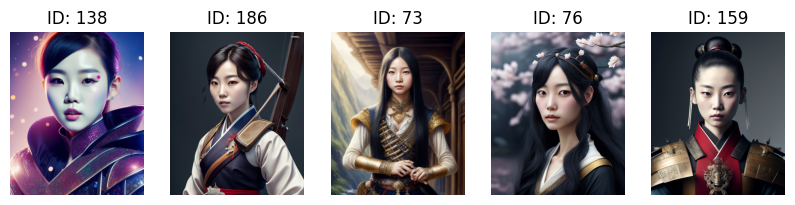

In [94]:
result_ids = [result.id for result in search_results[0]]
result_paths = [image_paths[id] for id in result_ids]
result_titles = [f"ID: {id}" for id, result in zip(result_ids, search_results[0])]

draw_images(result_paths, result_titles)

In [95]:
collection.release()